In [28]:
import time
import signal
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display, Markdown # Import 'display' and 'Markdown'
import matplotlib.pyplot as plt
import sys

sys.path.insert(0, str('../../'))

import SuguruSolvers
import SASolver

## Funções

In [31]:
def timeout_handler(signum, frame):
    raise Exception('EndOfTime')

def get_pickle_data(file_path):
    with open(file_path, 'rb') as fp:
        data = pickle.load(fp)
    return data

def get_instances():
    # Load instances
    instances = list()
    for root, dirs, files in os.walk('../../instances/generator'):
        for filename in files:
            file_path = os.path.join(root, filename)
            instances.append(file_path)
    return instances

def parse_suguru_binary(path):
    if not os.path.isfile(path):
        raise Exception('Error: invalid file path')

    # Load from file
    with open(path, 'rb') as fp:
        rows = int.from_bytes(fp.read(2))
        cols = int.from_bytes(fp.read(2))
        arr = np.fromfile(fp, dtype=np.int16).reshape(3, rows, cols)
    return arr

def run_solver(solver):
    results = dict()
    instances = get_instances()
    for instance in instances:
        grid, _, regions = parse_suguru_binary(instance)

        # Get puzzle statistics
        tips = np.count_nonzero(grid != 0)
        size = grid.size
        region_count = np.max(regions.flatten())
        
        # 5 Minute timeout
        signal.signal(signal.SIGALRM, timeout_handler)
        signal.alarm(30)

        # Solving using the current solver
        solved = False
        timeout = True
        try:
            s = solver(grid, regions)
            start = time.perf_counter()
            solved = s.solve()
            end = time.perf_counter()
            elapsed = end - start
        except Exception as e:
            print('Skipping by timeout...')
            solved = False
            timeout = True

        signal.alarm(0)
        
        if solver not in results:
            results[solver] = {'solved':list(), 'elapsed':list(), 'puzzle':list(), 'tips':list(), 'size':list(), 'region_count':list(), 'timeout':False}
        
        if solved:
            results[solver]['solved'].append(1)
            results[solver]['elapsed'].append(elapsed)
        else:
            results[solver]['solved'].append(0)
            results[solver]['elapsed'].append(np.inf)

        results[solver]['tips'].append(tips)
        results[solver]['puzzle'].append(instance)
        results[solver]['size'].append(size)
        results[solver]['region_count'].append(region_count)
        results[solver]['timeout'] = timeout
        
        if len(results[solver]['solved']) % 100 == 0:
            print('[i] Tested: ', len(results[solver]['solved']))
            
    return results[solver]


def analyze_solver_results(results_dict, solver_name="Solver"):
    """
    Analyzes and visualizes performance data for a single solver, 
    ensuring all tables render correctly in Jupyter Lab.
    """

    # 1. Data Preparation and Cleaning
    df = pd.DataFrame(results_dict)
    
    # Convert 0s and 1s to boolean (True/False)
    df['solved'] = df['solved'].astype(bool) 
    
    # Create a subset for time analysis (only solved puzzles)
    df_solved = df[df['solved'] == True].copy() 
    df_solved.dropna(subset=['elapsed'], inplace=True)
    
    if df.empty:
        print("ERROR: The results dictionary is empty or malformed.")
        return

    # 2. Statistical Tables
    
    display(Markdown("\n" + "="*70))
    display(Markdown("### 1. Descriptive Statistics Table (All Data) ###"))
    display(Markdown("="*70))
    
    # Descriptive stats table
    display(Markdown(df[['elapsed', 'tips', 'size']].describe().to_markdown(numalign="left", stralign="left")))
    
    display(Markdown("\n" + "="*70))
    display(Markdown("### 2. Key Performance Indicators (KPIs) ###"))
    display(Markdown("="*70))
    
    # Calculate KPIs
    total_puzzles = len(df)
    solved_count = df['solved'].sum()
    success_rate = solved_count / total_puzzles 
    
    # Prepare KPI DataFrame
    kpis_df = pd.DataFrame({
        'Metric': ['Total Puzzles', 'Puzzles Solved', 'Success Rate', 'Mean Solved Time', 'Median Solved Time', 'Mean Tips Used'],
        'Value': [
            total_puzzles, 
            solved_count, 
            success_rate, # Keep as number for formatting
            df_solved['elapsed'].mean(), # Keep as number for formatting
            df_solved['elapsed'].median(), # Keep as number for formatting
            df['tips'].mean()
        ]
    })
    
    # --- FIX APPLIED HERE: Using .style.format() to ensure clean HTML output ---
    # Apply formatting using the Styler object
    kpis_styled = kpis_df.style.format({
        'Success Rate': '{:.2%}',
        'Mean Solved Time': '{:.3f}s',
        'Median Solved Time': '{:.3f}s',
        'Mean Tips Used': '{:.2f}'
    }).hide(axis='index').set_properties(**{'text-align': 'left'}) # Hide index and align text
    
    display(kpis_styled) # Display the styled table
    # --------------------------------------------------------------------------
    
    display(Markdown("\n" + "="*70))
    display(Markdown("### 3. Grouped Statistics by Puzzle Size ###"))
    display(Markdown("="*70))
    
    # Grouped analysis (Success rate and time by 'size')
    if 'size' in df.columns:
        grouped_stats = df.groupby('size').agg(
            Attempted=('puzzle', 'size'),
            Success_Rate=('solved', 'mean'),
            Mean_Elapsed_Time=('elapsed', lambda x: x[df['solved']].mean()),
            Median_Tips=('tips', 'median')
        )
        display(grouped_stats.style.format({
            'Success_Rate': '{:.2%}',
            'Mean_Elapsed_Time': '{:.3f}s',
            'Median_Tips': '{:.1f}'
        }))
    else:
        print("Column 'size' not found for grouped analysis.")
        
    # 3. Visualization (Graphs)
    display(Markdown("\n" + "="*70))
    display(Markdown("### 4. Visualizations ###"))
    display(Markdown("="*70))
    
    # --- Figure 1: Distribution of Elapsed Time (Solved Puzzles) ---
    if not df_solved.empty:
        plt.figure(figsize=(10, 5))
        sns.histplot(df_solved['elapsed'], kde=True, bins=15, color='skyblue')
        plt.title(f'Elapsed Time Distribution for Solved Puzzles ({solver_name})', fontsize=14)
        plt.xlabel('Elapsed Time (seconds)')
        plt.ylabel('Frequency')
        plt.show()
    
    # --- Figure 2: Success Rate by Size (Bar Plot) ---
    if 'size' in df.columns:
        success_by_size = df.groupby('size')['solved'].mean().reset_index()
        plt.figure(figsize=(8, 5))
        sns.barplot(x='size', y='solved', data=success_by_size, palette='viridis')
        plt.title(f'Success Rate by Puzzle Size ({solver_name})', fontsize=14)
        plt.xlabel('Puzzle Size')
        plt.ylabel('Success Rate')
        plt.ylim(0, 1.05)
        plt.show()
        
    # --- Figure 3: Time vs. Difficulty (Scatter Plot) ---
    if not df_solved.empty:
        plt.figure(figsize=(10, 5))
        sns.scatterplot(x='tips', y='elapsed', data=df_solved, hue='size', palette='coolwarm', s=100)
        sns.regplot(x='tips', y='elapsed', data=df_solved, scatter=False, color='red', line_kws={'linestyle':'--'})
        plt.title(f'Elapsed Time vs. Tips (Difficulty) for Solved Puzzles ({solver_name})', fontsize=14)
        plt.xlabel('Tips Used (Proxy for Difficulty)')
        plt.ylabel('Elapsed Time (seconds)')
        plt.legend(title='Puzzle Size')
        plt.show()


    # 1. Calculate the normalized difficulty metric
    if 'size' in df.columns:
        # Calculate Tips/Size ratio
        df['tips_per_size'] = df['tips'] / df['size']
        
        # 2. Group by the new metric (rounding to 2 decimal places to create meaningful bins)
        success_by_tips_per_size = df.groupby(df['tips_per_size'].round(2))['solved'].mean().reset_index(name='Success_Rate')
        
        # 3. Calculate Pearson Correlation
        if len(success_by_tips_per_size) > 1:
            correlation_tips_size_success = success_by_tips_per_size['tips_per_size'].corr(success_by_tips_per_size['Success_Rate'])
        else:
             correlation_tips_size_success = np.nan

        display(Markdown("\n" + "="*70))
        display(Markdown("### 5. Correlation: Tips/Size Ratio vs. Success Rate ###"))
        display(Markdown("="*70))
        display(Markdown(f"**Pearson Correlation Coefficient (Tips/Size Ratio vs. Success Rate):** `{correlation_tips_size_success:.3f}`"))
        
        
        # --- Figure 5: Success Rate vs. Tips/Size Ratio (Scatter Plot with Trend) ---
        if not success_by_tips_per_size.empty and len(success_by_tips_per_size) > 1:
            
            # NOTE: You must move this entire block (starting from 'plt.figure') 
            # to the end of your '4. Visualizations' section.
            
            plt.figure(figsize=(10, 5))
            sns.regplot(
                x='tips_per_size', 
                y='Success_Rate', 
                data=success_by_tips_per_size, 
                scatter_kws={'s': 100, 'alpha': 0.7},
                line_kws={'color': 'red'}
            )
            plt.title(f'Success Rate by Normalized Difficulty (Tips/Size) ({solver_name})', fontsize=14)
            plt.xlabel('Tips / Puzzle Size (Grouped)')
            plt.ylabel('Success Rate')
            plt.ylim(-0.05, 1.05)
            plt.show()

    else:
        display(Markdown("\n**Skipping Tips/Size Correlation:** Column 'size' not found in data."))


## Motor Determinístico

In [3]:
# This might take very long!
# de_stats = evaluate_solver_stats(SuguruSolvers.DeterministicEngine)
de_stats = get_pickle_data('de.pkl')


======================================================================

### 1. Descriptive Statistics Table (All Data) ###

======================================================================

/home/lumberjack/Desktop/Github/Environments/ct208/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/lumberjack/Desktop/Github/Environments/ct208/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4671: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


|       | elapsed    | tips    | size    |
|:------|:-----------|:--------|:--------|
| count | 1700       | 1700    | 1700    |
| mean  | inf        | 52.6441 | 350.321 |
| std   | nan        | 86.144  | 575.56  |
| min   | 0.00242154 | 2       | 25      |
| 25%   | nan        | 9       | 64      |
| 50%   | nan        | 14      | 100     |
| 75%   | nan        | 56      | 400     |
| max   | inf        | 411     | 2500    |


======================================================================

### 2. Key Performance Indicators (KPIs) ###

======================================================================

Metric,Value
Total Puzzles,1700.000000
Puzzles Solved,191.000000
Success Rate,0.112353
Mean Solved Time,0.004970
Median Solved Time,0.004980
Mean Tips Used,52.644118



======================================================================

### 3. Grouped Statistics by Puzzle Size ###

======================================================================

,Attempted,Success_Rate,Mean_Elapsed_Time,Median_Tips
size,,,,
25,74,86.49%,0.004s,5.0
36,136,93.38%,0.006s,8.0
49,200,0.00%,nans,8.0
64,200,0.00%,nans,10.0
81,200,0.00%,nans,12.0
100,200,0.00%,nans,15.0
225,200,0.00%,nans,33.0
400,200,0.00%,nans,59.0
900,200,0.00%,nans,136.0



======================================================================

### 4. Visualizations ###

======================================================================

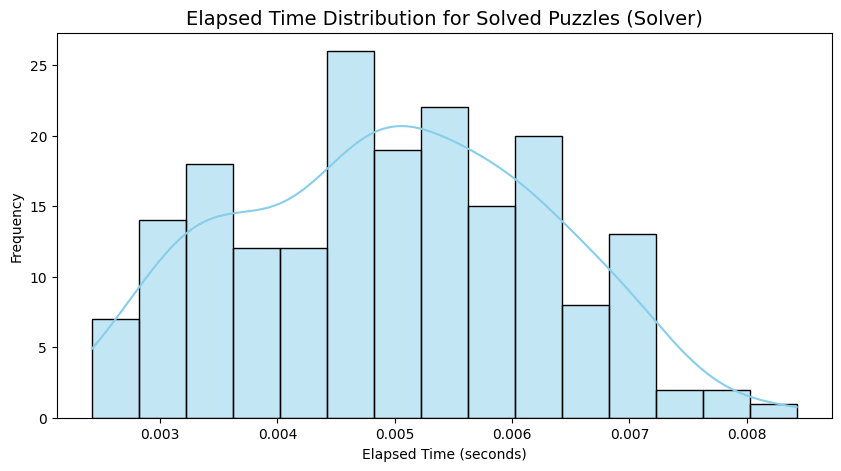

/tmp/ipykernel_4647/583989255.py:183: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='size', y='solved', data=success_by_size, palette='viridis')


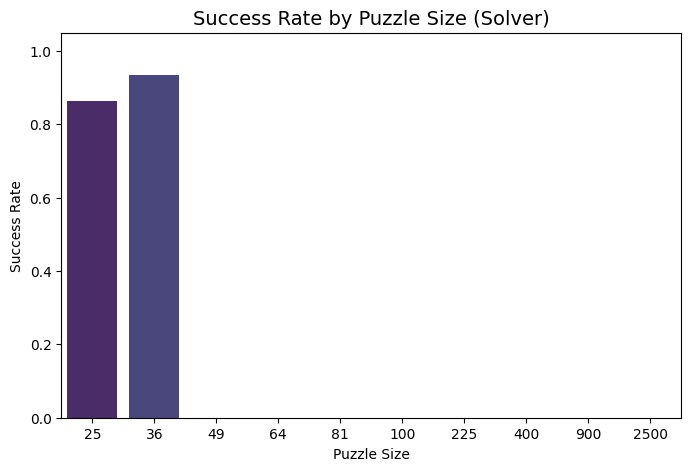

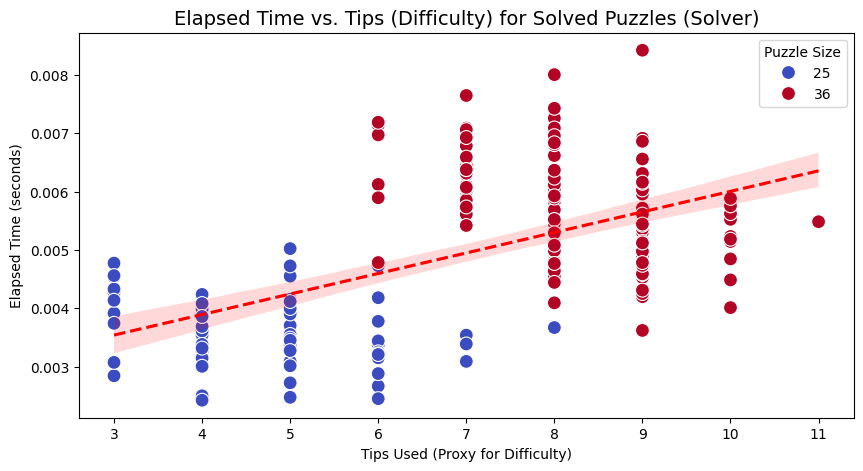


======================================================================

### 5. Correlation: Tips/Size Ratio vs. Success Rate ###

======================================================================

**Pearson Correlation Coefficient (Tips/Size Ratio vs. Success Rate):** `0.685`

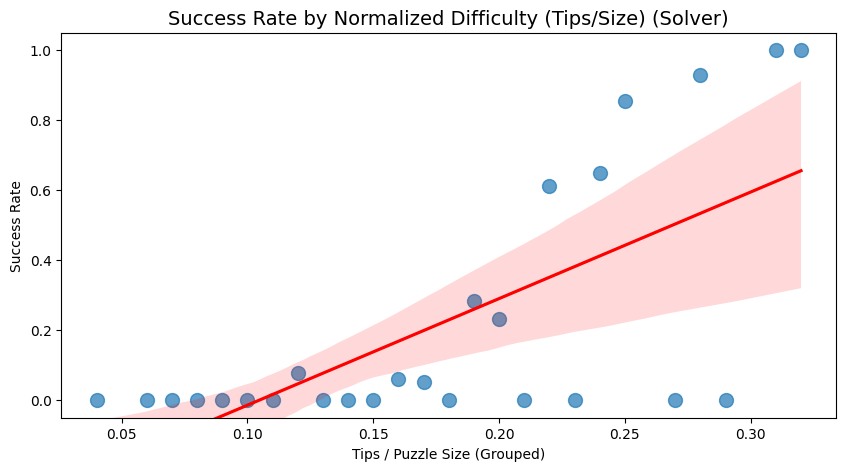

In [4]:
analyze_solver_results(de_stats)

## Simulated Annealing (Sem paralelismo)

In [32]:
# This might take very long!
sa_stats = run_solver(SASolver.SASolver)
#sa_stats = get_pickle_data('sa.pkl')

[i] Tested:  100
[i] Tested:  200
[i] Tested:  300
[i] Tested:  400
[i] Tested:  500
[i] Tested:  600
[i] Tested:  700
[i] Tested:  800
[i] Tested:  900
[i] Tested:  1000
[i] Tested:  1100
Skipping by timeout...
[i] Tested:  1200
Skipping by timeout...
Skipping by timeout...
Skipping by timeout...
Skipping by timeout...
Skipping by timeout...
Skipping by timeout...
Skipping by timeout...
Skipping by timeout...
Skipping by timeout...
Skipping by timeout...
[i] Tested:  1300
Skipping by timeout...
Skipping by timeout...
[i] Tested:  1400
Skipping by timeout...
Skipping by timeout...
Skipping by timeout...
Skipping by timeout...
Skipping by timeout...
Skipping by timeout...
Skipping by timeout...
Skipping by timeout...
Skipping by timeout...
Skipping by timeout...
Skipping by timeout...
Skipping by timeout...
Skipping by timeout...
Skipping by timeout...
Skipping by timeout...
Skipping by timeout...
Skipping by timeout...
Skipping by timeout...
Skipping by timeout...
Skipping by timeout..


======================================================================

### 1. Descriptive Statistics Table (All Data) ###

======================================================================

/home/lumberjack/Desktop/Github/Environments/ct208/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


|       | elapsed    | tips    | size    |
|:------|:-----------|:--------|:--------|
| count | 1700       | 1700    | 1700    |
| mean  | inf        | 52.6441 | 350.321 |
| std   | nan        | 86.144  | 575.56  |
| min   | 0.00261018 | 2       | 25      |
| 25%   | 0.0382057  | 9       | 64      |
| 50%   | 0.279086   | 14      | 100     |
| 75%   | 2.83586    | 56      | 400     |
| max   | inf        | 411     | 2500    |


======================================================================

### 2. Key Performance Indicators (KPIs) ###

======================================================================

Metric,Value
Total Puzzles,1700.000000
Puzzles Solved,1507.000000
Success Rate,0.886471
Mean Solved Time,1.668843
Median Solved Time,0.171412
Mean Tips Used,52.644118



======================================================================

### 3. Grouped Statistics by Puzzle Size ###

======================================================================

,Attempted,Success_Rate,Mean_Elapsed_Time,Median_Tips
size,,,,
25,74,100.00%,0.053s,5.0
36,136,100.00%,0.044s,8.0
49,200,99.00%,0.139s,8.0
64,200,99.50%,0.145s,10.0
81,200,99.50%,0.234s,12.0
100,200,99.50%,0.389s,15.0
225,200,96.00%,2.332s,33.0
400,200,93.50%,3.641s,59.0
900,200,61.50%,9.724s,136.0



======================================================================

### 4. Visualizations ###

======================================================================

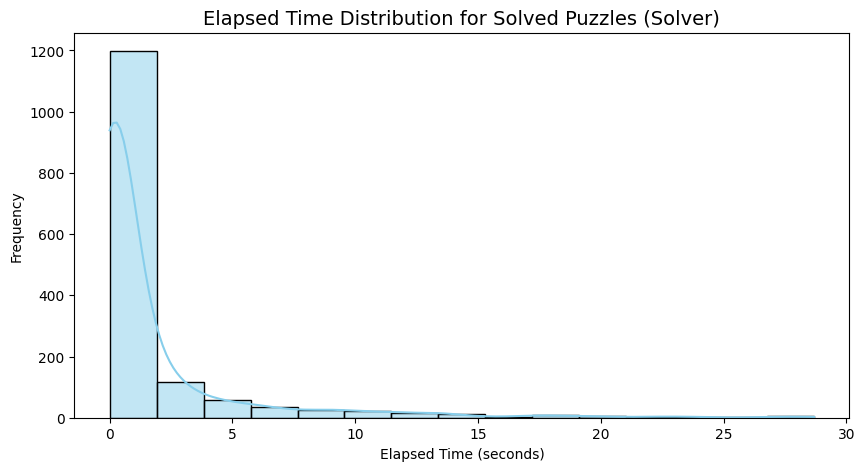

/tmp/ipykernel_4647/207046922.py:183: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='size', y='solved', data=success_by_size, palette='viridis')


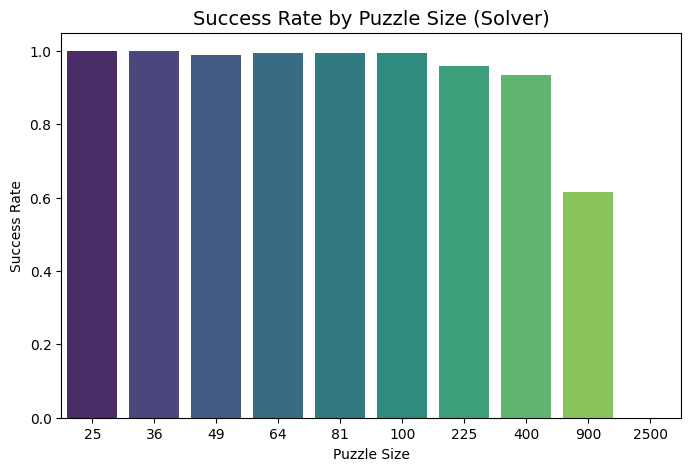

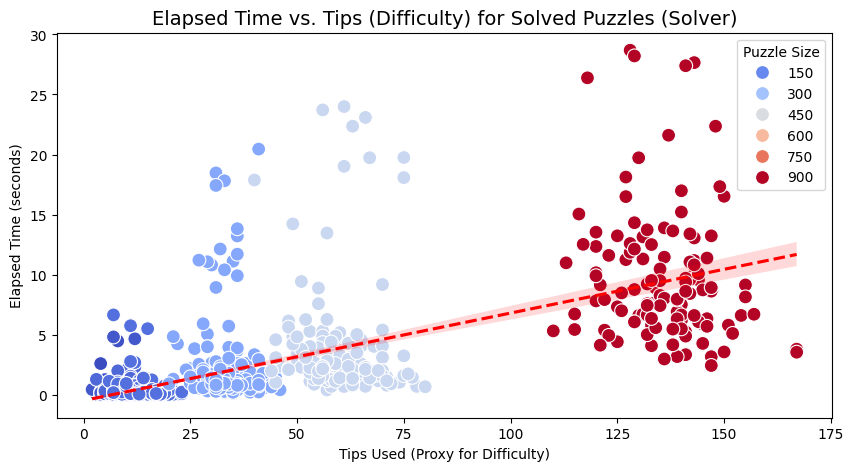


======================================================================

### 5. Correlation: Tips/Size Ratio vs. Success Rate ###

======================================================================

**Pearson Correlation Coefficient (Tips/Size Ratio vs. Success Rate):** `0.244`

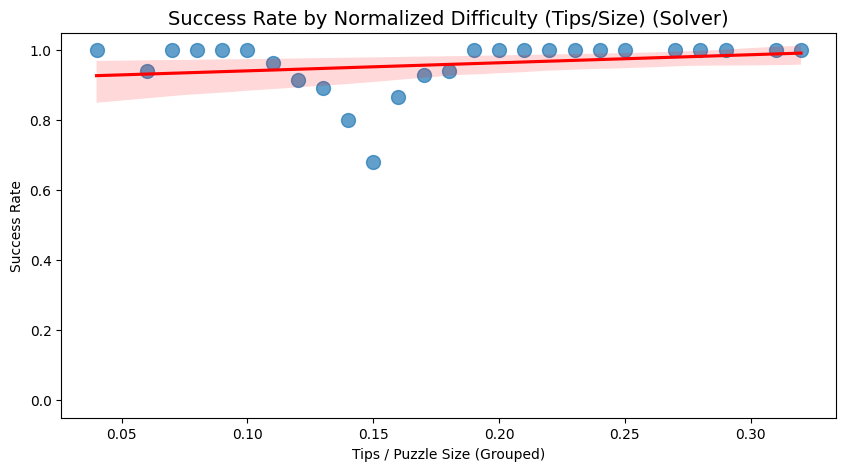

In [33]:
analyze_solver_results(sa_stats)

In [34]:
with open('sav2.0.pkl', 'wb') as fp:
    pickle.dump(sa_stats, fp)

## Backtrack (Força Bruta)

In [7]:
# This might take very long!
# bt_stats = evaluate_solver_stats(SuguruSolvers.BacktrackSolver)
bt_stats = get_pickle_data('bt.pkl')


======================================================================

### 1. Descriptive Statistics Table (All Data) ###

======================================================================

/home/lumberjack/Desktop/Github/Environments/ct208/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/lumberjack/Desktop/Github/Environments/ct208/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4671: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


|       | elapsed    | tips    | size    |
|:------|:-----------|:--------|:--------|
| count | 1700       | 1700    | 1700    |
| mean  | inf        | 52.6441 | 350.321 |
| std   | nan        | 86.144  | 575.56  |
| min   | 0.00429028 | 2       | 25      |
| 25%   | 0.230167   | 9       | 64      |
| 50%   | nan        | 14      | 100     |
| 75%   | nan        | 56      | 400     |
| max   | inf        | 411     | 2500    |


======================================================================

### 2. Key Performance Indicators (KPIs) ###

======================================================================

Metric,Value
Total Puzzles,1700.000000
Puzzles Solved,829.000000
Success Rate,0.487647
Mean Solved Time,2.222488
Median Solved Time,0.214376
Mean Tips Used,52.644118



======================================================================

### 3. Grouped Statistics by Puzzle Size ###

======================================================================

,Attempted,Success_Rate,Mean_Elapsed_Time,Median_Tips
size,,,,
25,74,100.00%,0.057s,5.0
36,136,100.00%,0.161s,8.0
49,200,100.00%,0.881s,8.0
64,200,80.00%,2.898s,10.0
81,200,81.50%,2.946s,12.0
100,200,48.00%,7.253s,15.0
225,200,0.00%,nans,33.0
400,200,0.00%,nans,59.0
900,200,0.00%,nans,136.0



======================================================================

### 4. Visualizations ###

======================================================================

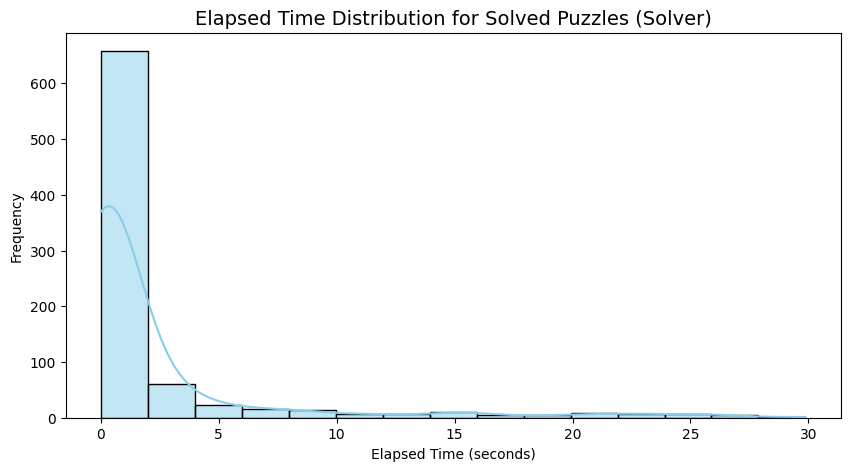

/tmp/ipykernel_4647/583989255.py:183: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='size', y='solved', data=success_by_size, palette='viridis')


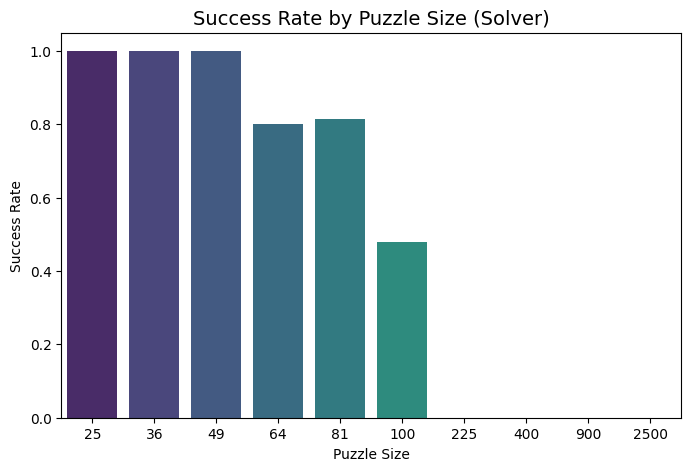

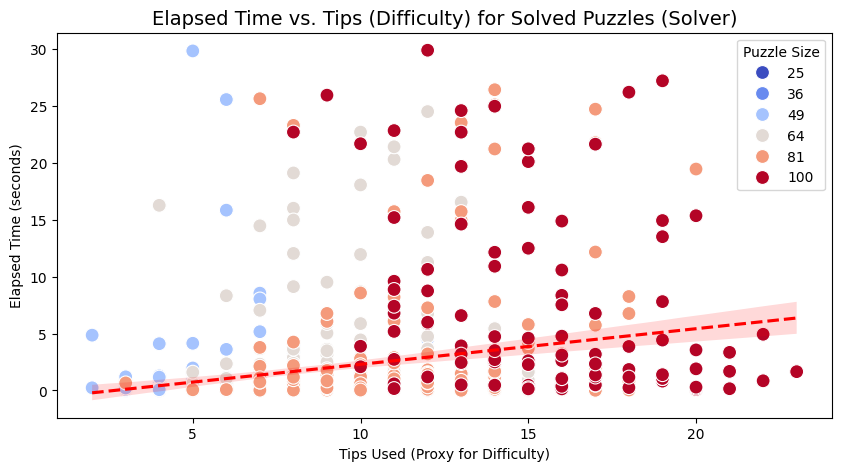


======================================================================

### 5. Correlation: Tips/Size Ratio vs. Success Rate ###

======================================================================

**Pearson Correlation Coefficient (Tips/Size Ratio vs. Success Rate):** `0.533`

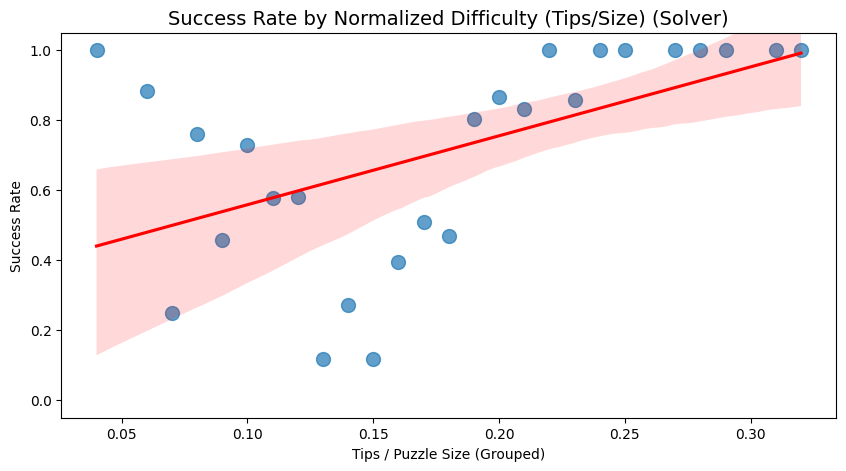

In [8]:
analyze_solver_results(bt_stats)

## Simulated Annealing (Versão com Paralelismo)

In [9]:
# This might take very long!
# sa_pl = evaluate_solver_stats(SASolver.ParallelSA)
sa_pl = get_pickle_data('sa_opt.pkl')


======================================================================

### 1. Descriptive Statistics Table (All Data) ###

======================================================================

/home/lumberjack/Desktop/Github/Environments/ct208/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


|       | elapsed   | tips    | size    |
|:------|:----------|:--------|:--------|
| count | 1700      | 1700    | 1700    |
| mean  | inf       | 52.6441 | 350.321 |
| std   | nan       | 86.144  | 575.56  |
| min   | 0.0531142 | 2       | 25      |
| 25%   | 0.143301  | 9       | 64      |
| 50%   | 0.51995   | 14      | 100     |
| 75%   | 6.49855   | 56      | 400     |
| max   | inf       | 411     | 2500    |


======================================================================

### 2. Key Performance Indicators (KPIs) ###

======================================================================

Metric,Value
Total Puzzles,1700.000000
Puzzles Solved,1444.000000
Success Rate,0.849412
Mean Solved Time,2.479459
Median Solved Time,0.307277
Mean Tips Used,52.644118



======================================================================

### 3. Grouped Statistics by Puzzle Size ###

======================================================================

,Attempted,Success_Rate,Mean_Elapsed_Time,Median_Tips
size,,,,
25,74,100.00%,0.137s,5.0
36,136,97.06%,0.087s,8.0
49,200,97.00%,0.361s,8.0
64,200,97.50%,0.293s,10.0
81,200,96.00%,0.469s,12.0
100,200,98.50%,0.801s,15.0
225,200,94.50%,3.844s,33.0
400,200,83.50%,5.146s,59.0
900,200,52.00%,15.364s,136.0



======================================================================

### 4. Visualizations ###

======================================================================

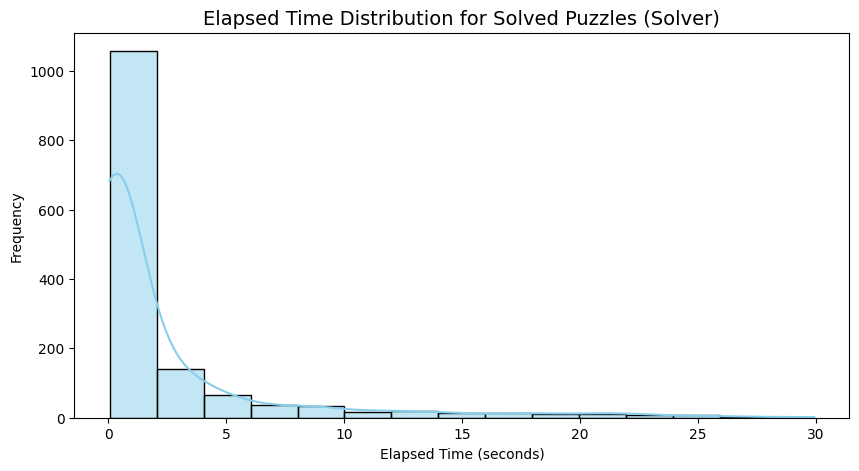

/tmp/ipykernel_4647/583989255.py:183: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='size', y='solved', data=success_by_size, palette='viridis')


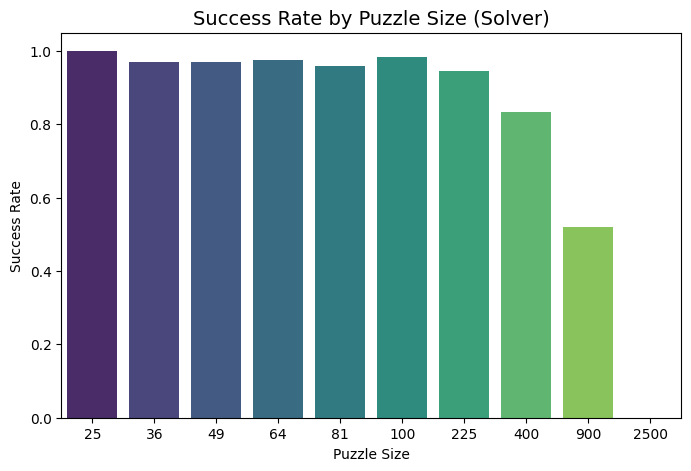

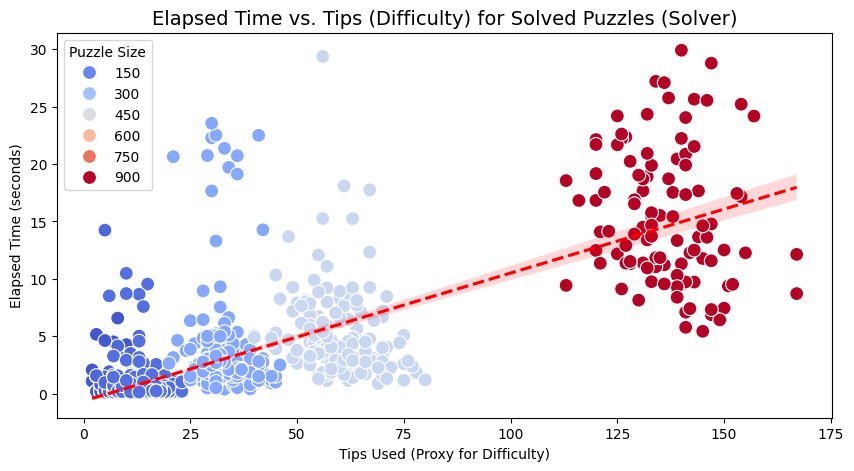


======================================================================

### 5. Correlation: Tips/Size Ratio vs. Success Rate ###

======================================================================

**Pearson Correlation Coefficient (Tips/Size Ratio vs. Success Rate):** `0.047`

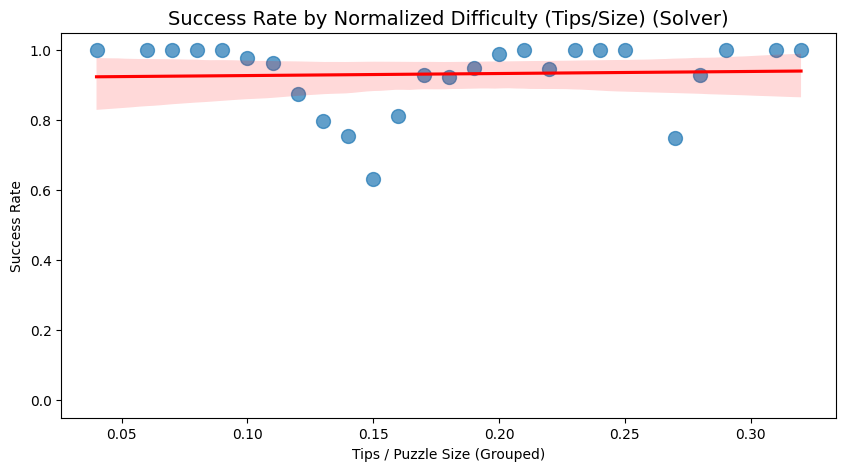

In [10]:
analyze_solver_results(sa_pl)